2.15.0
17225924/17225924 [==============================] - 1s 0us/step
調整 x_train 的圖片尺寸...
調整 x_test 的圖片尺寸...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
           

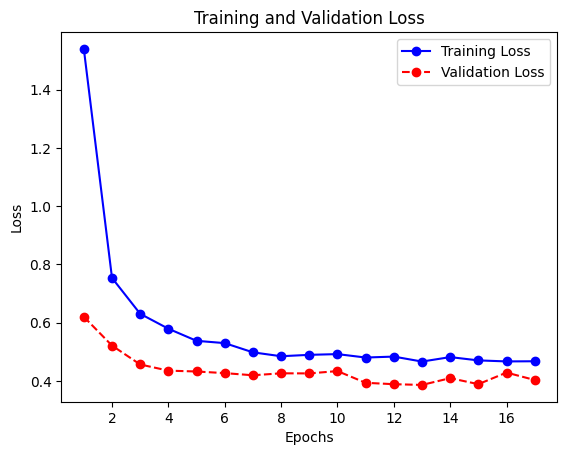

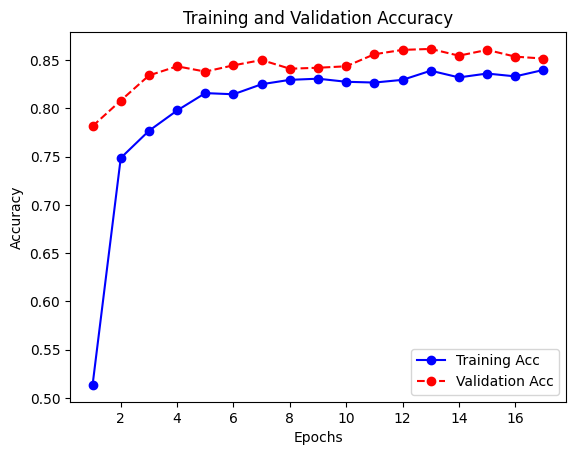

In [1]:
import tensorflow
print(tensorflow.__version__)

import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from PIL import Image

# 指定亂數種子
seed = 10
np.random.seed(seed)

# 載入資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 打亂 2 個 Numpy 陣列
def randomize(a, b):
    permutation = list(np.random.permutation(a.shape[0]))
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]

    return shuffled_a, shuffled_b

x_train, y_train = randomize(x_train, y_train)
x_test, y_test = randomize(x_test, y_test)

# 取出15%訓練, 20%測試
x_train = x_train[:7500]
y_train = y_train[:7500]
x_test = x_test[:2000]
y_test = y_test[:2000]

# One-hot編碼
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 載入 ResNet50 模型
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 調整 x_train 的圖片尺寸
print('調整 x_train 的圖片尺寸...')
x_train_new = np.array(
  [np.asarray(Image.fromarray(x_train[i]).resize(
          (224, 224))) for i in range(0, len(x_train))])
x_train_new = x_train_new.astype('float32')

# 訓練資料的資料前處理
train_input = preprocess_input(x_train_new)

# 調整 x_test 的圖片尺寸
print('調整 x_test 的圖片尺寸...')
x_test_new = np.array(
  [np.asarray(Image.fromarray(x_test[i]).resize(
          (224, 224))) for i in range(0, len(x_test))])
x_test_new = x_test_new.astype('float32')

# 測試資料的資料前處理
test_input = preprocess_input(x_test_new)

# 定義模型
model = Sequential()
model.add(mobilenet_model)
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()   # 顯示模型摘要資訊

# 凍結上層模型
mobilenet_model.trainable = False

# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 訓練模型
history = model.fit(train_input, y_train, validation_data=(test_input, y_test), epochs=17, batch_size=32, verbose=2)

# 評估模型
print('\nTesting ...')
loss, accuracy = model.evaluate(test_input, y_test, verbose=0)
print('測試資料集的準確度 = {:.2f}'.format(accuracy))

# 顯示圖表來分析模型的訓練過程
import matplotlib.pyplot as plt

# 顯示訓練和驗證損失
loss = history.history['loss']
epochs = range(1, len(loss)+1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 顯示訓練和驗證準確度
acc = history.history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo-', label='Training Acc')
plt.plot(epochs, val_acc, 'ro--', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()